In [1]:
import torch
import torchvision
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.tools import dotdict
from driver.driver import ABC_Driver
from torch_geometric_temporal import METRLADatasetLoader
from other_model.other_model import make_default_model
import atd2022
torch.cuda.is_available()
torch.cuda.set_device(4)

In [2]:
atd_args = dotdict()

atd_args.name = 'atd'
atd_args.train_batch_size = 25
atd_args.predict_len = 4
atd_args.history_len = 7

atd_args.train_epochs= 10
atd_args.lr = 0.00009
atd_args.criterion = 'L1'
atd_args.scheduler = None

activation = 'relu'
pool_name = 'avg'
input_channel = 1
pixel_number = atd_args.history_len*5200
kernel_size = 6
knpp = 12
knpp2 = atd_args.predict_len

atd_args.layers=[
    ('agnostic', ((input_channel, knpp, kernel_size), 1, None, None, activation)),
    ('agnostic', ((knpp, knpp2, kernel_size), 1, None, None, activation)),
    ('linear', (knpp2*atd_args.history_len, atd_args.predict_len, (1,2), 1, (1, atd_args.predict_len))),
]

In [3]:
wt_args = dotdict()

wt_args.name = 'wiki_traffic'
wt_args.train_batch_size = 30
wt_args.predict_len = 1
wt_args.history_len = 5

wt_args.train_epochs= 10
wt_args.lr = 0.001
wt_args.criterion = 'L1'
wt_args.scheduler = None

activation = 'relu'
pool_name = 'avg'
input_channel = 1
pixel_number = wt_args.history_len*1400
kernel_size = 3
knpp = 5
knpp2 = 15

wt_args.layers=[
    ('specific', ((input_channel, knpp, kernel_size), 1, None, None, activation)),
    ('specific', ((knpp, knpp2, kernel_size), 1, None, None, activation)),
    ('linear', (knpp2*wt_args.history_len, wt_args.predict_len, (1,2), 1, (1, wt_args.predict_len))),
]

In [4]:
lat_args = dotdict()

lat_args.name = 'lat'
lat_args.train_batch_size = 30
lat_args.predict_len = 1
lat_args.history_len = 5

lat_args.train_epochs= 10
lat_args.lr = 0.001
lat_args.criterion = 'L1'
lat_args.scheduler = None

activation = 'relu'
pool_name = 'avg'
input_channel = 1
pixel_number = lat_args.history_len*207
kernel_size = 3
knpp = 5
knpp2 = 15

lat_args.layers=[
    ('specific', ((input_channel, knpp, kernel_size), 1, None, None, activation)),
    ('specific', ((knpp, knpp2, kernel_size), 1, None, None, activation)),
    ('linear', (knpp2*lat_args.history_len, lat_args.predict_len, (1,2), 1, (1, lat_args.predict_len))),
]

In [5]:
mnist_args = dotdict()

mnist_args.name = 'mnist'
mnist_args.train_batch_size = 120
mnist_args.predict_batch_size = 100


mnist_args.train_epochs = 30
mnist_args.lr = 0.001
mnist_args.criterion = 'CE'
mnist_args.optimizer = 'Adam'
mnist_args.scheduler = 'multistep3'
mnist_args.attack = {'fgsm':(0.1,), 'pgd':(0.1,0.1,20)}

activation = 'relu'
input_channel = 1
knpp = [30,60,120,180,240]

mnist_args.layers=[
    ('cnn2d', ((input_channel, knpp[0], (7,7), 1, 3, 1, 1), 1, None, None, activation, False)),
    ('atc2d', ((knpp[0], knpp[1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, True)),
    ('atc2d', ((knpp[1], knpp[2], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
    ('atc2d', ((knpp[2], knpp[3], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, True)),
    ('atc2d', ((knpp[3], knpp[4], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
    ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
    ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 0, 1, knpp[0]), 1, None, None, False, False)),
    ('adptavgpool', (1,1)),
    ('linear', (knpp[-1], 10, (1,2,3))),
    ('softmax', (1))
]

# knpp = [24,48,96,192]
# # knpp = [30,60,120,240]

# mnist_args.layers=[
#     ('cnn2d', ((input_channel, knpp[0], (3,3), 1, 1, 1, 1), 1, None, None, activation, False)),
#     ('atc2d', ((knpp[0], knpp[1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, True)),
#     ('atc2d', ((knpp[1], knpp[2], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
#     ('atc2d', ((knpp[2], knpp[3], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 0, 1, knpp[0]), 1, None, None, activation, False)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 0, 1, knpp[0]), 1, None, None, False, False)),
#     ('adptavgpool', (1,1)),
#     ('linear', (knpp[-1], 10, (1,2,3))),
#     ('softmax', (1))
# ]

In [6]:
cifar10_args = dotdict()

cifar10_args.name = 'cifar10'
cifar10_args.device = ['cuda:4']
cifar10_args.model = 'convmixer'
cifar10_args.train_batch_size = 100
cifar10_args.predict_batch_size = 100

cifar10_args.train_epochs = 250
cifar10_args.lr = 0.2
cifar10_args.criterion = 'CE'
cifar10_args.optimizer = 'SGD'
cifar10_args.scheduler = 'multistep'
cifar10_args.attack = {'deepfool':(0.005,0.1,20)}

activation = 'relu'
input_channel = 3
# knpp = [40,80,160,240,320]

# cifar10_args.layers=[
#     ('cnn2d', ((input_channel, knpp[0], (3,3), 1, 1, 1, 1), 1, None, None, activation, False)),
#     ('atc2d', ((knpp[0], knpp[1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, True)),
#     ('atc2d', ((knpp[1], knpp[2], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
#     ('atc2d', ((knpp[2], knpp[3], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, True)),
#     ('atc2d', ((knpp[3], knpp[4], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, True)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 0, 1, knpp[0]), 1, None, None, False, False)),
#     ('adptavgpool', (1,1)),
#     ('linear', (knpp[-1], 10, (1,2,3))),
#     ('softmax', (1))
# ]

# resnet
cifar10_args.layers=[
    ('cnn2d', ((3, 16, (3, 3), 1, 1), 1, None, None, 'relu', False)), 
    ('cnn2d', ((16, 16, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((16, 16, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((16, 16, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((16, 32, (3, 3), 1, 1), 2, 'first', (2, 2), 'relu')), 
    ('cnn2d', ((32, 32, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((32, 32, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((32, 64, (3, 3), 1, 1), 2, 'first', (2, 2), 'relu')), 
    ('cnn2d', ((64, 64, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('cnn2d', ((64, 64, (3, 3), 1, 1), 2, None, None, 'relu')), 
    ('adptavgpool', (1, 1)), 
    ('linear', (64, 10, (1, 2, 3)))
]

# abccnn
# knpp = [32,64,96,128,160,192,224]
# cifar10_args.layers=[
#     ('cnn2d', ((input_channel, knpp[0], (3,3), 1, 1, 1, 1), 1, None, None, activation, False)),
#     ('cnn2d', ((knpp[0], knpp[1], (3,3), 1, 1, 1, 1), 2, None, None, activation, True)),
#     ('cnn2d', ((knpp[1], knpp[2], (3,3), 1, 1, 1, 1), 2, 'first', (2,2), activation, True)),
#     ('cnn2d', ((knpp[2], knpp[3], (3,3), 1, 1, 1, 1), 2, None, None, activation, True)),
#     ('cnn2d', ((knpp[3], knpp[4], (3,3), 1, 1, 1, 1), 2, 'first', (2,2), activation, True)),
#     ('cnn2d', ((knpp[4], knpp[5], (3,3), 1, 1, 1, 1), 2, None, None, activation, True)),
#     ('cnn2d', ((knpp[5], knpp[6], (3,3), 1, 1, 1, 1), 2, 'first', (2,2), activation, True)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (3,3), 1, 0, 1, 1), 1, None, None, activation, False)),
#     ('cnn2d', ((knpp[-1], knpp[-1], (2,2), 1, 0, 1, 1), 1, None, None, False, False)),
# #     ('adptavgpool', (1,1)),
#     ('linear', (knpp[-1], 10, (1,2,3))),
#     ('softmax', (1))
# ]


# knpp = [48,96,144,240,336,432,528,624]

# cifar10_args.layers=[
#     ('cnn2d', ((input_channel, knpp[0], (3,3), 1, 1, 1, 1), 1, None, None, activation, False)),
#     ('atrc2d', ((knpp[0], knpp[1], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('atrc2d', ((knpp[1], knpp[2], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, False)),
#     ('atrc2d', ((knpp[2], knpp[3], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('atrc2d', ((knpp[3], knpp[4], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('atrc2d', ((knpp[4], knpp[5], (3,3), 1, 1, 1, knpp[0]), 1, 'first', (2,2), activation, False)),
#     ('atrc2d', ((knpp[5], knpp[6], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('atrc2d', ((knpp[6], knpp[7], (3,3), 1, 1, 1, knpp[0]), 1, None, None, activation, False)),
#     ('adptavgpool', (1,1)),
#     ('linear', (knpp[-1], 10, (1,2,3)))
# ]

In [7]:
args = cifar10_args
data = None
# data = atd2022.io.read_csv()
# data = pd.read_csv('/scratch/mfeng/data/ABC/Wiki_Traffic/filled_selected_train_1.csv', index_col=0, header=[0,1,2,3], parse_dates=True)
# data = pd.read_csv('/scratch/mfeng/data/ABC/LA_Traffic/LA_Traffic.csv', index_col=0)
# data = data.head(200)

driver = ABC_Driver(args, data, record_path=None, if_hash=False)
# driver.train()

Use: ['cuda:4']
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
add record: 03/29/2023 10:34


In [8]:
driver.model.load_state_dict(torch.load("save/CIFAR10_CNM_2023_03_22.pt"))

<All keys matched successfully>

In [9]:
driver.metric(test_attack=True)

/scratch/mfeng/anaconda/envs/atd2022/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


clean       0.9609
deepfool    0.2768
dtype: float64

In [8]:
args = cifar10_args
data = None
# data = atd2022.io.read_csv()
# data = pd.read_csv('/scratch/mfeng/data/ABC/Wiki_Traffic/filled_selected_train_1.csv', index_col=0, header=[0,1,2,3], parse_dates=True)
# data = pd.read_csv('/scratch/mfeng/data/ABC/LA_Traffic/LA_Traffic.csv', index_col=0)
# data = data.head(200)

driver = ABC_Driver(args, data, record_path=None, if_hash=False)
driver.train()

Use: ['cuda:4', 'cuda:5']
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
add record: 03/26/2023 09:48
epoch: 0, train_loss: 1.7715, test_metric: 0.5299, time: 640.1170034408569
epoch: 1, train_loss: 1.4424, test_metric: 0.6315, time: 637.0665020942688
epoch: 2, train_loss: 1.2745, test_metric: 0.6749, time: 636.9777297973633
epoch: 3, train_loss: 1.1583, test_metric: 0.7091, time: 637.0282580852509
epoch: 4, train_loss: 1.0692, test_metric: 0.7112, time: 636.8239636421204
epoch: 5, train_loss: 1.0016, test_metric: 0.7649, time: 637.0339353084564
epoch: 6, train_loss: 0.9575, test_metric: 0.7776, time: 637.1081812381744
epoch: 7, train_loss: 0.9159, test_metric: 0.7787, time: 637.2223207950592
epoch: 8, train_loss: 0.88, test_metric: 0.7857, time: 636.9696855545044
epoch: 9, train_loss: 0.8496, test_metric: 0.8027, time: 637.4048428535461
epoch: 10, train_loss: 0.828, test_metric: 0.8049, time: 637.2197160720825
epoch: 1

EmptyDataError: No columns to parse from file

In [24]:
driver.continue_train(driver, empty_epoch=83)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83, train_loss: 0.1823, test_metric: 0.9318, time: 5990.81659078598
epoch: 84, train_loss: 0.1833, test_metric: 0.9349, time: 639.365318775177
epoch: 85, train_loss: 0.1742,

epoch: 181, train_loss: 0.0591, test_metric: 0.9476, time: 568.4377429485321
epoch: 182, train_loss: 0.0581, test_metric: 0.9485, time: 568.5046916007996
epoch: 183, train_loss: 0.0585, test_metric: 0.9505, time: 568.4857637882233
epoch: 184, train_loss: 0.0556, test_metric: 0.9503, time: 568.3831586837769
epoch: 185, train_loss: 0.0548, test_metric: 0.9499, time: 568.5427484512329
epoch: 186, train_loss: 0.0552, test_metric: 0.95, time: 568.578533411026
epoch: 187, train_loss: 0.0533, test_metric: 0.9523, time: 568.418653011322
epoch: 188, train_loss: 0.057, test_metric: 0.9509, time: 568.6109220981598
epoch: 189, train_loss: 0.0542, test_metric: 0.9511, time: 568.3951909542084
epoch: 190, train_loss: 0.0531, test_metric: 0.95, time: 568.4420664310455
epoch: 191, train_loss: 0.0539, test_metric: 0.9498, time: 568.4476237297058
epoch: 192, train_loss: 0.0524, test_metric: 0.9501, time: 568.4691927433014
epoch: 193, train_loss: 0.0519, test_metric: 0.9523, time: 568.5345854759216
epoch:

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [47]:
plt.imshow(np.array(driver.data_loader.attack[-1].dataset[0][0].permute(1,2,0)),aspect='auto')
plt.show()

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


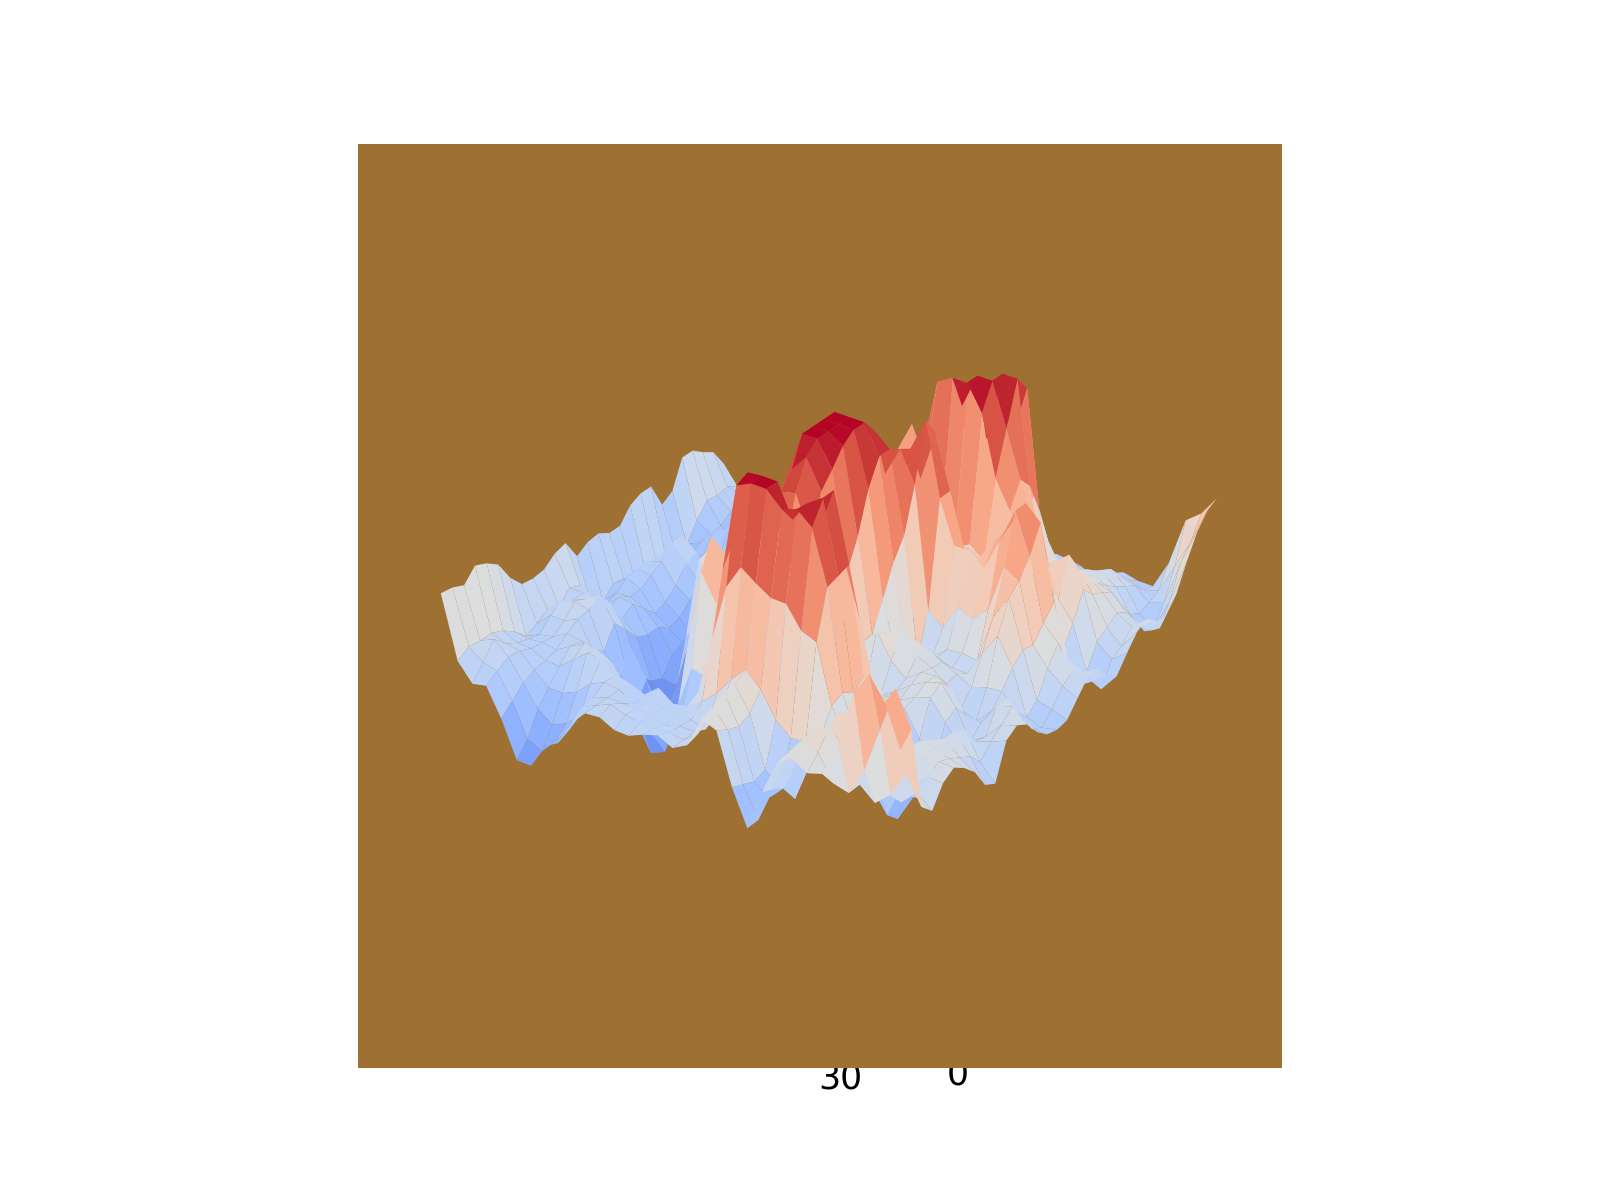

/tmp/ipykernel_2066608/4173571449.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个二维数组
data = np.random.rand(32, 32)
data = np.array(driver.data_loader.train.dataset[0][0][1])

# 创建X,Y坐标轴
x = np.arange(0, 32, 1)
y = np.arange(0, 32, 1)
X, Y = np.meshgrid(x, y)

# 绘制三维曲面
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, data, cmap='coolwarm')

# 隐藏y轴刻度标签
ax.set_zticks([])
ax.set_zticklabels([])

plt.show()

In [7]:
args = cifar10_args
data = None
# data = atd2022.io.read_csv()
# data = pd.read_csv('/scratch/mfeng/data/ABC/Wiki_Traffic/filled_selected_train_1.csv', index_col=0, header=[0,1,2,3], parse_dates=True)
# data = pd.read_csv('/scratch/mfeng/data/ABC/LA_Traffic/LA_Traffic.csv', index_col=0)
# data = data.head(200)

driver = ABC_Driver(args, data, record_path=None, if_hash=False)
driver.train()

Use: ['cuda:4', 'cuda:5']
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
add record: 03/21/2023 11:04


/scratch/mfeng/anaconda/envs/atd2022/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 0, train_loss: 2.0763, test_metric: 0.413, time: 289.0976550579071
epoch: 1, train_loss: 1.884, test_metric: 0.5155, time: 288.3746621608734
epoch: 2, train_loss: 1.7553, test_metric: 0.5697, time: 288.291672706604
epoch: 3, train_loss: 1.6458, test_metric: 0.6063, time: 288.28107476234436
epoch: 4, train_loss: 1.5531, test_metric: 0.6638, time: 288.22270011901855
epoch: 5, train_loss: 1.4642, test_metric: 0.6931, time: 288.1883018016815
epoch: 6, train_loss: 1.3969, test_metric: 0.703, time: 288.2314326763153
epoch: 7, train_loss: 1.315, test_metric: 0.735, time: 288.2426607608795
epoch: 8, train_loss: 1.2554, test_metric: 0.7478, time: 288.2106845378876
epoch: 9, train_loss: 1.2057, test_metric: 0.7549, time: 288.1534719467163
epoch: 10, train_loss: 1.1694, test_metric: 0.7699, time: 288.209885597229
epoch: 11, train_loss: 1.1257, test_metric: 0.7825, time: 288.2334530353546
epoch: 12, train_loss: 1.0954, test_metric: 0.7712, time: 288.1428027153015
epoch: 13, train_loss: 1.06

epoch: 108, train_loss: 0.3777, test_metric: 0.9412, time: 287.9883668422699
epoch: 109, train_loss: 0.3887, test_metric: 0.9437, time: 287.950807094574
epoch: 110, train_loss: 0.3817, test_metric: 0.943, time: 287.8674190044403
epoch: 111, train_loss: 0.379, test_metric: 0.9447, time: 287.7202353477478
epoch: 112, train_loss: 0.3799, test_metric: 0.946, time: 287.66538071632385
epoch: 113, train_loss: 0.3789, test_metric: 0.9443, time: 287.76473593711853
epoch: 114, train_loss: 0.3664, test_metric: 0.9436, time: 287.71680641174316
epoch: 115, train_loss: 0.3766, test_metric: 0.9458, time: 288.0416684150696
epoch: 116, train_loss: 0.3668, test_metric: 0.9424, time: 287.70735359191895
epoch: 117, train_loss: 0.3637, test_metric: 0.9414, time: 287.7299499511719
epoch: 118, train_loss: 0.3617, test_metric: 0.9441, time: 287.80285120010376
epoch: 119, train_loss: 0.3569, test_metric: 0.9471, time: 287.7107663154602
epoch: 120, train_loss: 0.3536, test_metric: 0.946, time: 287.7586705684662

epoch: 216, train_loss: 0.2067, test_metric: 0.9588, time: 287.6445314884186
epoch: 217, train_loss: 0.2021, test_metric: 0.9591, time: 287.7555732727051
epoch: 218, train_loss: 0.2063, test_metric: 0.961, time: 287.795289516449
epoch: 219, train_loss: 0.2037, test_metric: 0.9595, time: 287.84113788604736
epoch: 220, train_loss: 0.2048, test_metric: 0.9587, time: 287.84378814697266
epoch: 221, train_loss: 0.2069, test_metric: 0.9578, time: 287.67720079421997
epoch: 222, train_loss: 0.204, test_metric: 0.9584, time: 287.70468521118164
epoch: 223, train_loss: 0.2024, test_metric: 0.9594, time: 287.7460083961487
epoch: 224, train_loss: 0.2044, test_metric: 0.959, time: 287.6248080730438
epoch: 225, train_loss: 0.2018, test_metric: 0.9596, time: 287.7586979866028
epoch: 226, train_loss: 0.1963, test_metric: 0.9602, time: 287.6660256385803
epoch: 227, train_loss: 0.2032, test_metric: 0.9592, time: 287.7652473449707
epoch: 228, train_loss: 0.197, test_metric: 0.9597, time: 287.7005877494812


In [25]:
# torch.save(driver.model.state_dict(), "save/CIFAR10_CNM_2023_03_22.pt")
# driver.model.load_state_dict(torch.load("save/CIFAR10_CNM_2023_03_22.pt"))